In [1]:
try:
    import scienceplots
    import rootutils
except ModuleNotFoundError:
    !pip install SciencePlots
    !pip install rootutils
    
import shutup
shutup.please()

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

import warnings
warnings.filterwarnings('ignore')

import rootutils
ROOT = rootutils.setup_root(indicator='README.md', search_from=os.path.abspath(''), pythonpath=True, cwd=True)

import jax
import jax.numpy as jnp
import numpy as np
GLOBAL_KEY = jax.random.key(42)

import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])

# Lagrangian Potentials

from ott.neural.methods.lagrangian.lagrangian_potentials import *

# Potentials

In [2]:
plot_params_src = {
        "edgecolors": "black",
        "color": "red",
        "alpha": 0.35
    }

plot_params_tgt = {
    "edgecolors": "black",
    "color": "green",
    "alpha": 0.35
}

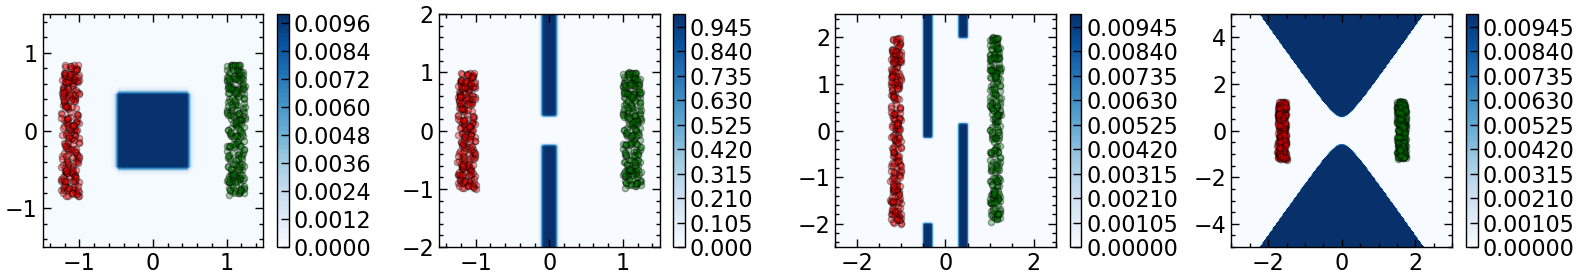

In [3]:
potentials = [BoxPotential, SlitPotential, BabyMazePotential, VNeck_Potential]

x = jnp.linspace(-2.5, 2.5, 100)
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(16, 3))

key = GLOBAL_KEY
for i, ax in enumerate(axs.flatten()):
    potential = potentials[i]()
    fig, ax = plot_potential(potential=potential, ax=axs[i])
    key = jax.random.fold_in(key, i)
    key, sample_key = jax.random.split(key, 2)
    
    if isinstance(potential, BoxPotential):
        source_data, target_data = potential.get_samples(size=256)
        axs[i].scatter(source_data[:,0], source_data[:, 1], s=20, **plot_params_src)
        axs[i].scatter(target_data[:, 0], target_data[:, 1], s=20, **plot_params_tgt)
    
    elif isinstance(potential, VNeck_Potential):
        source_data, target_data = potential.get_samples(size=256, key=sample_key)
        axs[i].scatter(source_data[:,0], source_data[:, 1], s=20, **plot_params_src)
        axs[i].scatter(target_data[:, 0], target_data[:, 1], s=20, **plot_params_tgt)
        
    elif isinstance(potential, BabyMazePotential):
        source_data, target_data = potential.get_samples(size=256, key=sample_key)
        axs[i].scatter(source_data[:,0], source_data[:, 1], s=20, **plot_params_src)
        axs[i].scatter(target_data[:, 0], target_data[:, 1], s=20, **plot_params_tgt)

    elif isinstance(potential, SlitPotential):
        source_data, target_data = potential.get_samples(size=256, key=sample_key)
        axs[i].scatter(source_data[:,0], source_data[:, 1], s=20, **plot_params_src)
        axs[i].scatter(target_data[:, 0], target_data[:, 1], s=20, **plot_params_tgt)
    
plt.tight_layout()

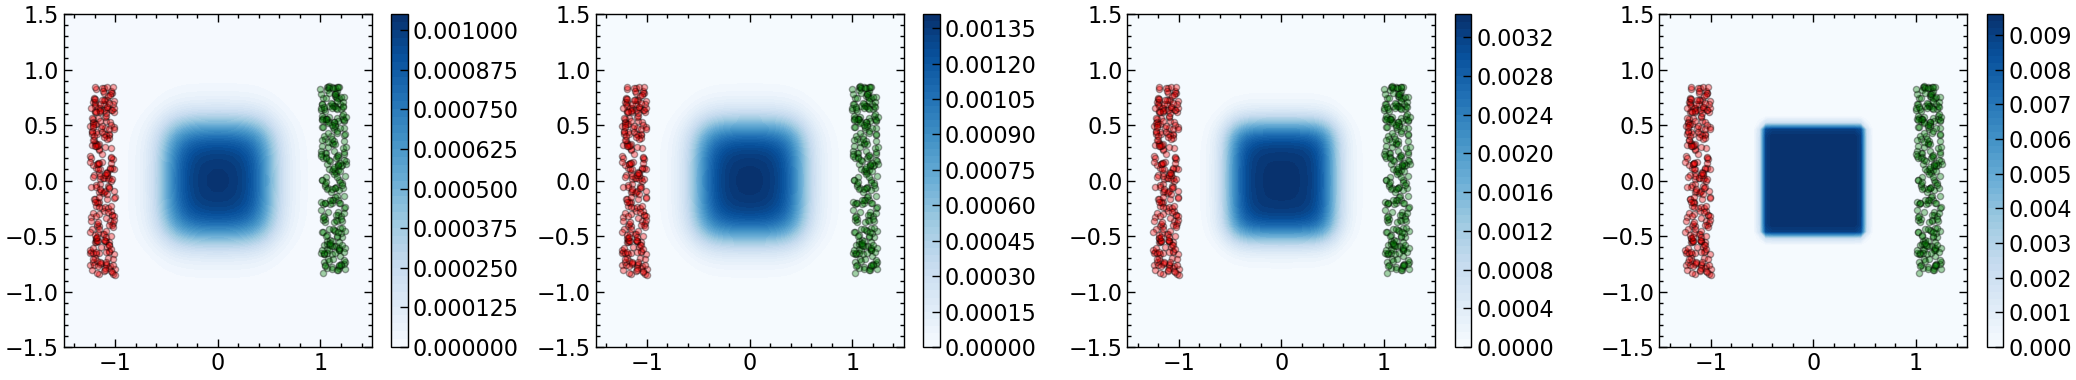

In [4]:
box_potential = BoxPotential()
source_data, target_data = box_potential.get_samples(size=256)

fig, axs = plt.subplots(ncols=4, nrows=1, figsize = (21, 4), sharex=False, sharey=False)

for i, time in zip(range(4), [0.001, 0.2, 0.4, 0.8]):
    fig, ax = plot_potential(box_potential.get_annealed_params(time), fig=fig, ax=axs[i])
    ax.scatter(source_data[:,0], source_data[:, 1], s=20, **plot_params_src)
    ax.scatter(target_data[:, 0], target_data[:, 1], s=20, **plot_params_tgt)
    
plt.tight_layout()

# GSBM

In [5]:
from ott.neural.methods.gsbm import GSBM

potential = BoxPotential().get_annealed_params(t=0.85)
potential_data_loader = iter(potential.sampler_func(batch_size=512))
x0 = next(potential_data_loader)['src_lin']
x1 = next(potential_data_loader)['tgt_lin']

gsbm = GSBM.create(potential=potential)._initialize(x0, x1, GLOBAL_KEY)
init_gammas = gsbm.get_final_gammas()
init_means = gsbm.get_final_xt()
# num_iterations=10_001

# gsbm = gsbm(gsbm, n_iters=num_iterations, rng=GLOBAL_KEY)
# samples = gsbm.sample_xt(gsbm, jnp.linspace(0, 1, 20), params=gsbm.state.params, rng=GLOBAL_KEY)
# final_gammas = gsbm.get_final_gammas()

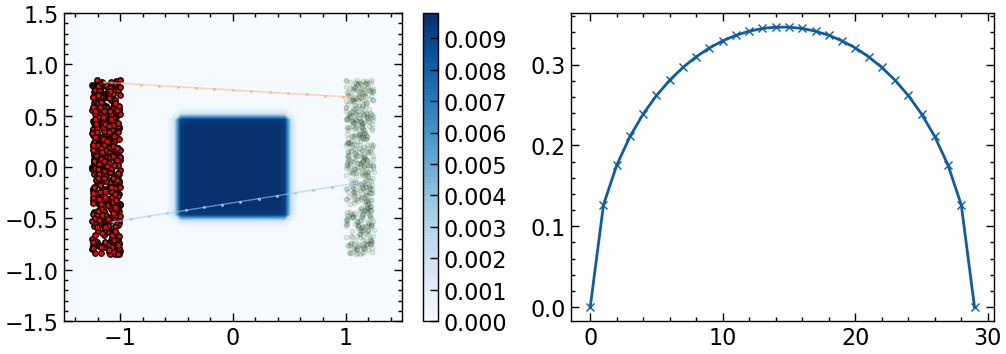

In [9]:
pi0 = next(potential_data_loader)['src_lin']
pi1 = next(potential_data_loader)['tgt_lin']

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig, ax0 = plot_potential(potential=potential, fig=fig, ax=ax[0], invert_sign=False)
draw_trajs(init_means[:, :2], ax=ax0)
ax0.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=15, edgecolors='black')
ax0.scatter(pi1[:,0], pi1[:, 1], c='green', alpha=0.1, s=10, edgecolors='black')
ax0.set_xlim(*potential.x_axes_bounds)
ax0.set_ylim(*potential.y_axes_bounds)

ax[1].plot(init_gammas[0], "-x")
#ax[1].plot(final_gammas[0], "-x", c='orange')
plt.show()

# Neural Optimal Control (ours)

In [12]:
from ott.neural.methods.nocc import NeuralOC
from ott.neural.methods.flows.dynamics import LagrangianFlow
import flax.linen as nn
from IPython.display import clear_output

potential = BoxPotential().get_annealed_params(t=0.85)
potential_data_loader = iter(potential.sampler_func(batch_size=1024))

def callback(step, training_logs, transport):
    clear_output()
    pi0 = next(potential_data_loader)['src_lin']
    pi1 = next(potential_data_loader)['tgt_lin']

    cost, trajs = transport(pi0)

    fig, ax = plt.subplots()
    fig, ax = plot_potential(potential=potential, fig=fig, ax=ax)
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4)
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10)
    ax.scatter(trajs[-1].x[:, 0], trajs[-1].x[:, 1], c='green', s=10)
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=jnp.stack([traj.x for traj in trajs])[:, :100], ax=ax)
    plt.show()

class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, x, _):
        x = jnp.concatenate([x, t] + [jnp.sin(t*k) / (10 * k) for k in range(1,5)] + [jnp.cos(t*k) / (10 * k) for k in range(1,5)], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x
    
class CorrectionMLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, src, tgt):
        x = jnp.concatenate([src, tgt], -1)
        x = jnp.concatenate([x, t], -1)# + [jnp.sin(t*k) / (10 * k) for k in range(1,5)] + [jnp.cos(t*k) / (10 * k) for k in range(1,5)], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x
     
net = MLP(hidden_layers=[256, 256, 256, 1])
corr_net = CorrectionMLP(hidden_layers=[512, 512, 2])
num_iterations = 50_000
lr_schedule = optax.cosine_decay_schedule(
    init_value=2e-5, decay_steps=num_iterations, alpha=1e-2
)
noc = NeuralOC(input_dim=2, 
               value_model=net, 
               optimizer=optax.adam(learning_rate=lr_schedule), 
               correction_model=corr_net,
               correction_optimizer=optax.adam(learning_rate=1e-4), 
               control_weight=2.0, 
               potential_weight=400, 
               flow=LagrangianFlow(sigma=0.8, potential=potential), 
               key=GLOBAL_KEY)

In [ ]:
logs = noc(potential_data_loader, n_iters=num_iterations, rng=GLOBAL_KEY, callback=callback)

In [11]:
from ott.neural.methods.nocc import NeuralOC
from ott.neural.methods.flows.dynamics import LagrangianFlow
import flax.linen as nn
from IPython.display import clear_output

potential = SlitPotential().get_annealed_params(t=0.9)
potential_data_loader = iter(potential.sampler_func(batch_size=512, key=GLOBAL_KEY))

def callback(step, training_logs, transport):
    clear_output()
    pi0 = next(potential_data_loader)['src_lin']
    pi1 = next(potential_data_loader)['tgt_lin']

    cost, trajs = transport(pi0)

    fig, ax = plt.subplots()
    fig, ax = plot_potential(potential=potential, fig=fig, ax=ax)
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4)
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10)
    ax.scatter(trajs[-1].x[:, 0], trajs[-1].x[:, 1], c='green', s=10)
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=jnp.stack([traj.x for traj in trajs])[:, :50], ax=ax)
    plt.show()

class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, x, _):
        x = jnp.concatenate([x, t] + [jnp.sin(t*k) / (10 * k) for k in range(1,5)] + [jnp.cos(t*k) / (10 * k) for k in range(1,5)], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x
    
class CorrectionMLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, src, tgt):
        x = jnp.concatenate([src, tgt], -1)
        x = jnp.concatenate([x, t] + [jnp.sin(t*k) / (10 * k) for k in range(1,5)] + [jnp.cos(t*k) / (10 * k) for k in range(1,5)], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x
     
net = MLP(hidden_layers=[256, 256, 256, 1])
corr_net = CorrectionMLP(hidden_layers=[1024, 1024, 2])
num_iterations = 100_000
# lr_schedule = optax.cosine_decay_schedule(
#     init_value=2e-4, decay_steps=num_iterations, alpha=1e-2
# )
noc = NeuralOC(input_dim=2, 
               value_model=net, 
               optimizer=optax.adam(learning_rate=1e-5), 
               correction_model=corr_net,
               correction_optimizer=optax.adam(learning_rate=1e-5), 
               control_weight=1.0, 
               potential_weight=70, 
               flow=LagrangianFlow(sigma=0.01, potential=potential), 
               key=GLOBAL_KEY)

In [ ]:
logs = noc(potential_data_loader, n_iters=num_iterations, rng=GLOBAL_KEY, callback=callback)

In [5]:
from ott.neural.methods.nocc import NeuralOC
from ott.neural.methods.flows.dynamics import LagrangianFlow
import flax.linen as nn
from IPython.display import clear_output

potential = BabyMazePotential().get_annealed_params(t=0.9)
potential_data_loader = iter(potential.sampler_func(batch_size=1024, key=GLOBAL_KEY))

def callback(step, training_logs, transport):
    clear_output()
    pi0 = next(potential_data_loader)['src_lin']
    pi1 = next(potential_data_loader)['tgt_lin']

    cost, trajs = transport(pi0)

    fig, ax = plt.subplots()
    fig, ax = plot_potential(potential=potential, fig=fig, ax=ax)
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4)
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10)
    ax.scatter(trajs[-1].x[:, 0], trajs[-1].x[:, 1], c='green', s=10)
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=jnp.stack([traj.x for traj in trajs])[:, :50], ax=ax)
    plt.show()

class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, x, _):
        x = jnp.concatenate([x, t] + [jnp.sin(t*k) / (10 * k) for k in range(1,5)] + [jnp.cos(t*k) / (10 * k) for k in range(1,5)], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x
    
class CorrectionMLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, src, tgt):
        x = jnp.concatenate([src, tgt], -1)
        x = jnp.concatenate([x, t] + [jnp.sin(t*k) / (10 * k) for k in range(1,5)] + [jnp.cos(t*k) / (10 * k) for k in range(1,5)], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x
     
net = MLP(hidden_layers=[128, 128, 128, 1])
corr_net = CorrectionMLP(hidden_layers=[1024, 1024, 2])
num_iterations = 100_000
lr_schedule = optax.cosine_decay_schedule(
    init_value=1e-4, decay_steps=num_iterations, alpha=1e-2
)
noc = NeuralOC(input_dim=2, 
               value_model=net, 
               optimizer=optax.adam(learning_rate=lr_schedule), 
               correction_model=corr_net,
               correction_optimizer=optax.adam(learning_rate=1e-5), 
               control_weight=2.0, 
               potential_weight=10, 
               flow=LagrangianFlow(sigma=0.01, potential=potential), 
               key=GLOBAL_KEY)

In [ ]:
logs = noc(potential_data_loader, n_iters=num_iterations, rng=GLOBAL_KEY, callback=callback)